# Gaussian process-based Bayesian optimization

Prepared by Maxim Ziatdinov (2022), adapted by SVK

As described in earlier examples, Gaussian process (GP) is a powerful tool for reconstructing an unknown function from sparse measurements in the probabilistic fashion. In addition to providing a "one-off" reconstruction, the GP's posterior predictive mean and uncertainty can be used to derive an acquisition function for selecting the next point to measure in the optimization problems. Specifically, the next measurement point is selected according to

$$ x_{next}= \underset{x}{\arg\max}\frac{1}{L}∑_{i=1}^Lα(𝜇_*^i,𝓥_*^i)$$

for maximization problems and

$$ x_{next}= \underset{x}{\arg\min}\frac{1}{L}∑_{i=1}^Lα(𝜇_*^i,𝓥_*^i)$$

for minimization problems. Here $L$ is the total number of Hamiltonian Monte Carlo samples,  $𝜇_*^i$ is a posterior predictive mean, and $𝓥_*^i$ is a posterior predictive variance for *i*-th sample. Perhaps the simplest acquisition function is an upper confidence bound (UCB) defined as

$$ α_{UCB}^i= 𝜇_*^i\pm\sqrt{𝛽\space 𝓥_*^i}, $$

where the square root of 𝓥 is a standard deviation (‘uncertainty’). We note that instead of $\frac{1}{L}∑_{i=1}^Lα(𝜇_*^i,𝓥_*^i)$, one could in principle use $α(\bar{f_*}, 𝓥[f_*])$, where $\bar{f_*}$ and $𝓥[f_*]$ are the mean and variance of predictions sampled from the multivariate normal posterior at each point (```y_sampled``` in gpax examples).  The coefficient $𝛽$ determines an exploitation-exploration trade-off. The '$+$' sign corresponds to the maximization problems, whereas the '$-$' sign is for the minimization problems.


Install GPax:

In [ ]:
!pip install git+https://github.com/ziatdinovmax/gpax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/ziatdinovmax/gpax to /tmp/pip-req-build-kvrgp301
  Running command git clone --filter=blob:none --quiet https://github.com/ziatdinovmax/gpax /tmp/pip-req-build-kvrgp301
  Resolved https://github.com/ziatdinovmax/gpax to commit df47afd077daca2eef5a572363b7d734881ab4e4
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.2/300.2 KB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 352.1/352.1 KB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.3/71.3 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 11.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for gpax: filename=gpax-0.0.6-py3-none-any.whl size=39032 sha256=22a743e898b4359041816a353e52909b2910d498e5d143b7502f25b89ffbf32d
  Stored in directory: /tmp/pip-ephem-wheel-cache-zz5it

Imports:

In [ ]:
import gpax
import numpy as np
import matplotlib.pyplot as plt

import numpyro

gpax.utils.enable_x64()

Let's define a function to be minimized and a function that emulates a noisy measurement:

SVK Note: Here, the function is ground truth. This is how nature behaves, but we do not know it. Purpose of the experiment is either learn this function (EU aquisition function), or discover minimum of this function (UCB aquisition function). Note that parameter beta in UCB determines balance between the explorationa and exploitation (if we set beta to zero, we make algorithm greedy so it get trapped into whatever minimum it discovers first). Also note that the noise that we add is a measurement noise that we define a priori. Experimentalist does not know what it is - you actually aim to learn it from the experiment. 

In [ ]:
def func(x, y=1.2):
    out = (
        -20 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2)))
        - np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y)))
        + np.e + 20
    )
    return out

def measure(x, noise=0.3):
    return func(x) + noise * np.random.randn(len(x))

Next, we generate a few noisy observations of our function. We also plot the true function ("ground truth") to confirm the location of the minimum at $x=0$ but we are not going to use it anywhere. 

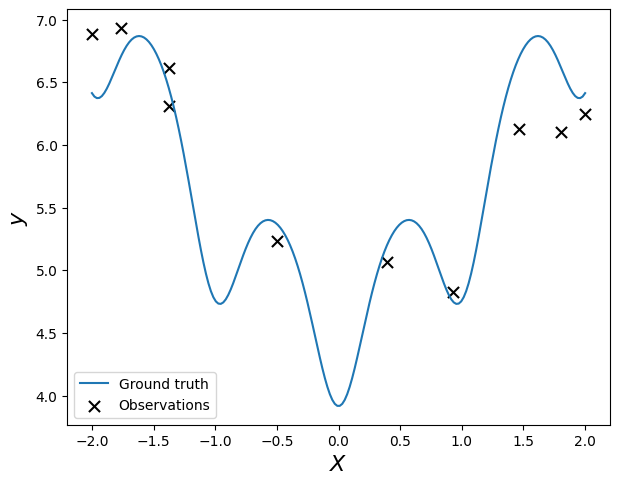

In [ ]:
np.random.seed(42)

X_bounds = np.array([-2, 2])
X = np.random.uniform(X_bounds[0], X_bounds[1], size=(8,))
X = np.append(X, X_bounds)
X = np.sort(X)
y = measure(X)

X_unmeasured = np.linspace(X_bounds[0], X_bounds[1], 200)
ground_truth = measure(X_unmeasured, noise=0)


_, ax = plt.subplots(dpi=100, figsize=(7, 5.5))
ax.set_xlabel("$X$", fontsize=16)
ax.set_ylabel("$y$", fontsize=16)
ax.scatter(X, y, marker='x', c='k', s=64, zorder=1, label="Observations", alpha=1.0)
ax.plot(X_unmeasured, ground_truth, label='Ground truth')
ax.legend(loc='best');

The Gaussian process class in GPax uses a weakly informative $LogNormal(0,1)$ prior distribution for all kernel parameters and model noise by default. If we have prior knowledge that the noise level is low, we may choose a more appropriate prior distibution for the noise, such as

SVK note: Here, priors on noise and kernel length and scale are our best guesses before the experiment on how the measurement system behaves. Noise is combined effect of how precise are our measurements and how significant are other (uncontrollable) factors that affect the measurements. Kernel lengthscale is basically how rapidly we think the properties can change. Scale is simplest - it is just vertical scale. These guesses are very important - for example, if we think that our measurements are very precise (noise is small) but in reality noise is high, then algorithm will interpret each noise peak as as peak in ground truth (and can go horribly wrong by making kernel length very small). At the same time, if we set kernel length too large, it can never find small modulations in the function. Experiment with these paprameters! Noise in the ground truth vs. noise in the prior, and too big/too small kernel lengths. 

In [ ]:
noise_prior = lambda: numpyro.sample("noise", numpyro.distributions.HalfNormal(1.0))

In [ ]:
def gp_kernel_prior():
    length = numpyro.sample("k_length", numpyro.distributions.Uniform(0.1, 2.0))
    scale = numpyro.sample("k_scale", numpyro.distributions.LogNormal(0, 1))
    # the hyperparameters are returned as dictionary
    return {"k_length": length, "k_scale": scale}

Next we define a single step that takes measured data, trains a GP model, and uses it to compute an Upper Confidence Bound (UCB) acquisition function for deriving the next measurment point (which will be done inside the main loop).

In [ ]:
def step(X_measured, y_measured, X_unmeasured):
    # Get random number generator keys for training and prediction
    rng_key1, rng_key2 = gpax.utils.get_keys()
    # Initialize GP model
    gp_model = gpax.ExactGP(1, kernel='Matern', kernel_prior=gp_kernel_prior, noise_prior=noise_prior)
    # Run HMC to obtain posterior samples for the GP model parameters
    gp_model.fit(rng_key1, X_measured, y_measured)
    # Get predictions (we don't need this step for optimization - only for visualization purposes)
    y_pred, y_sampled = gp_model.predict(rng_key2, X_unmeasured, noiseless=True)
    
    # Compute acquisition function
    # Upper confidence bound
    # obj = gpax.acquisition.UCB(
    #     rng_key2, gp_model, X_unmeasured, beta=0.01, #4
    #     maximize=False, noiseless=True)
    
    # pure uncertainty-based
    obj = gpax.acquisition.UE(
        rng_key2, gp_model, X_unmeasured, 
        noiseless=True)
    
    
    return obj, (y_pred, y_sampled)

Finally, we run the Bayesian optimization for 7 steps to find the minimum of the unknown (to the algorithm) function:


Step 1/25


sample: 100%|██████████| 4000/4000 [00:13<00:00, 288.63it/s, 7 steps of size 7.00e-01. acc. prob=0.89]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      1.71      0.22      1.77      1.39      2.00   1936.30      1.00
   k_scale      9.76      4.52      8.69      3.68     15.83   1092.95      1.00
     noise      0.17      0.19      0.11      0.01      0.36   1069.05      1.00



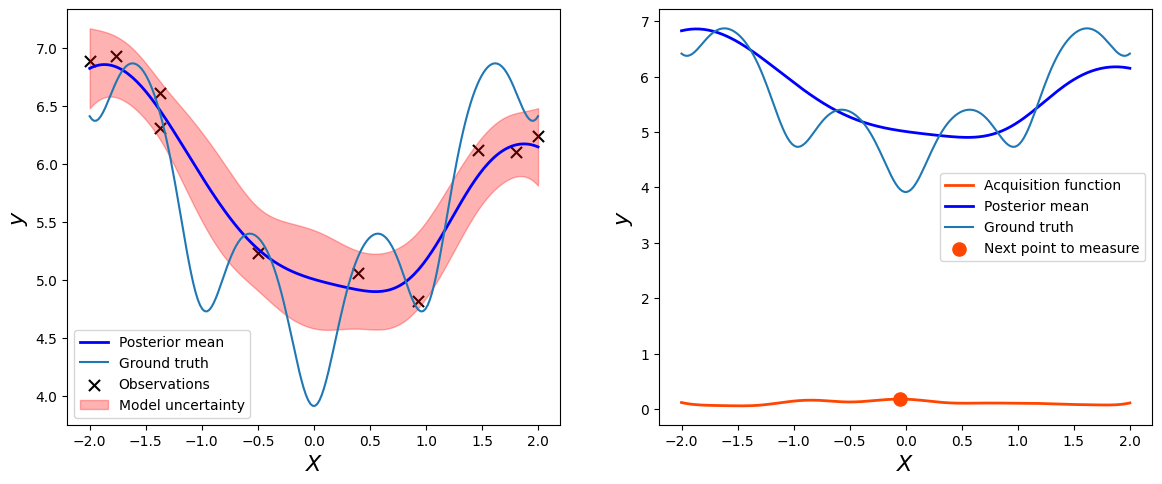


Step 2/25


sample: 100%|██████████| 4000/4000 [00:09<00:00, 403.58it/s, 7 steps of size 6.87e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      1.68      0.24      1.74      1.32      2.00   1756.87      1.00
   k_scale      9.95      4.56      8.86      3.71     16.00   1028.33      1.00
     noise      0.35      0.26      0.27      0.05      0.66   1684.04      1.00



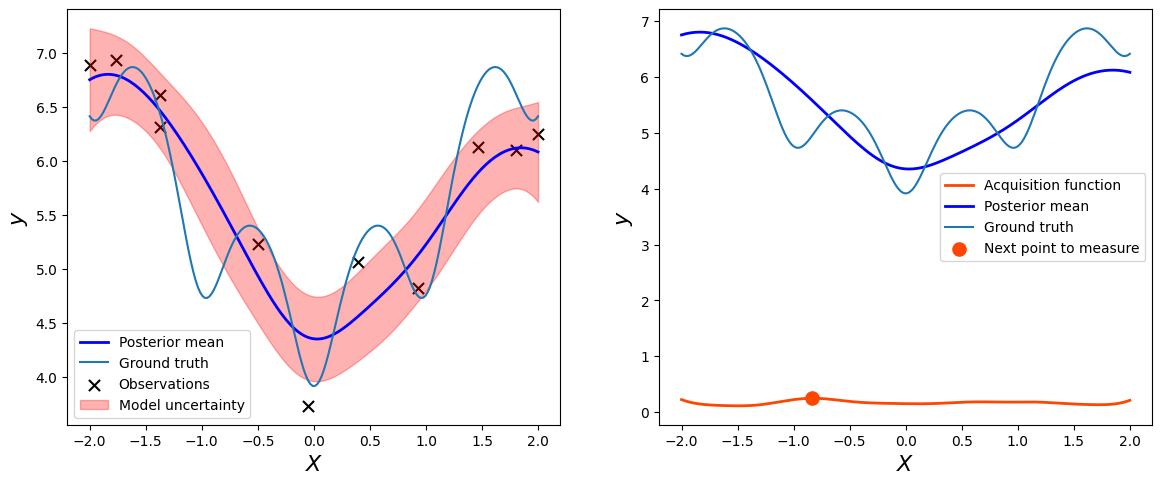


Step 3/25


sample: 100%|██████████| 4000/4000 [00:09<00:00, 404.28it/s, 7 steps of size 6.29e-01. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      1.70      0.24      1.75      1.37      2.00   1452.23      1.00
   k_scale      9.69      4.57      8.66      3.66     15.85   1212.69      1.00
     noise      0.35      0.25      0.28      0.08      0.67   1387.83      1.00



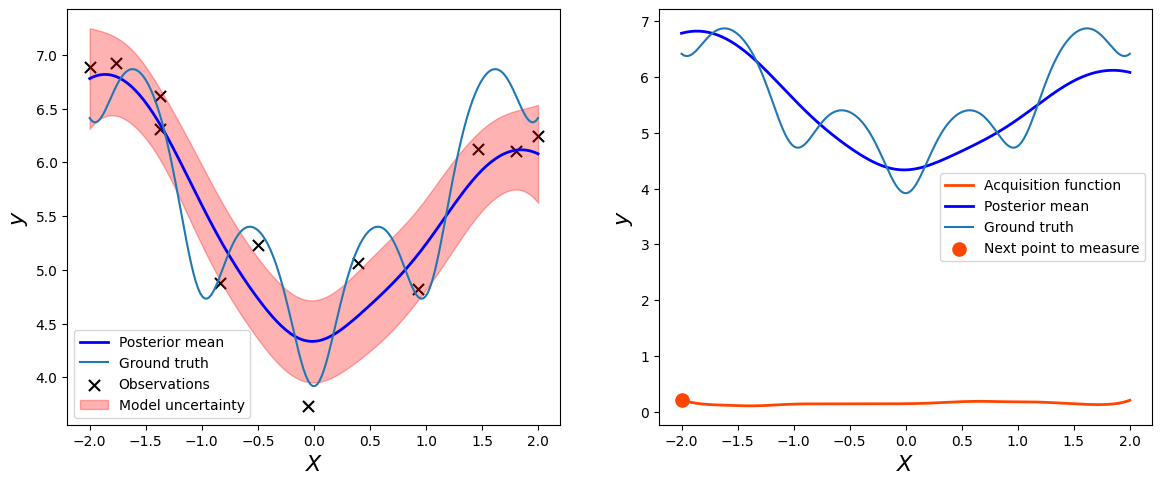


Step 4/25


sample: 100%|██████████| 4000/4000 [00:09<00:00, 402.05it/s, 7 steps of size 6.93e-01. acc. prob=0.89]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      1.70      0.23      1.75      1.38      2.00   1726.33      1.00
   k_scale      9.74      4.56      8.67      3.88     16.05   1157.43      1.00
     noise      0.34      0.22      0.28      0.07      0.61   1365.42      1.00



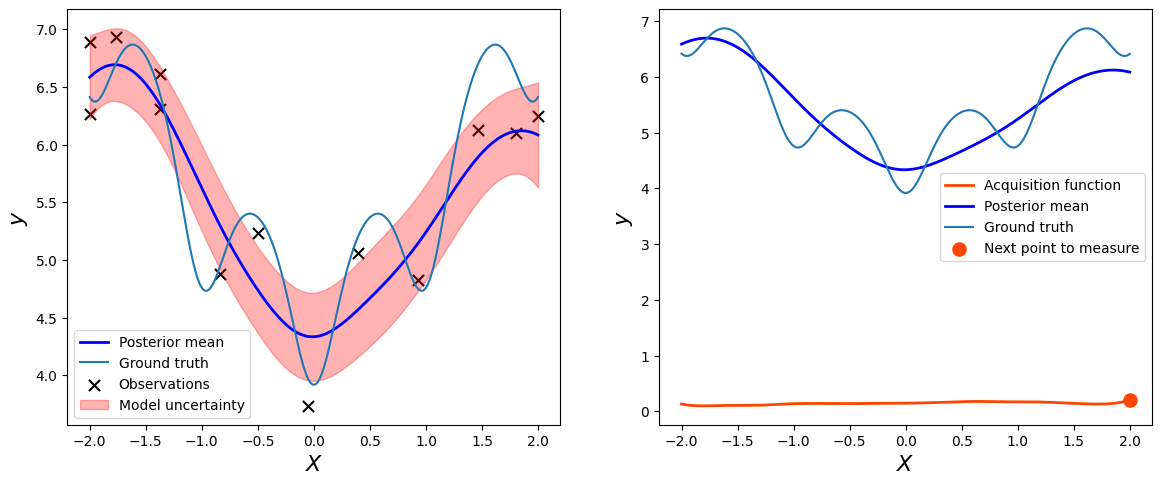


Step 5/25


sample: 100%|██████████| 4000/4000 [00:10<00:00, 384.99it/s, 3 steps of size 8.01e-01. acc. prob=0.85]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      1.70      0.23      1.76      1.38      2.00   1848.27      1.00
   k_scale      9.88      4.65      8.82      4.14     16.50   1282.32      1.00
     noise      0.30      0.20      0.25      0.07      0.54   1394.81      1.00



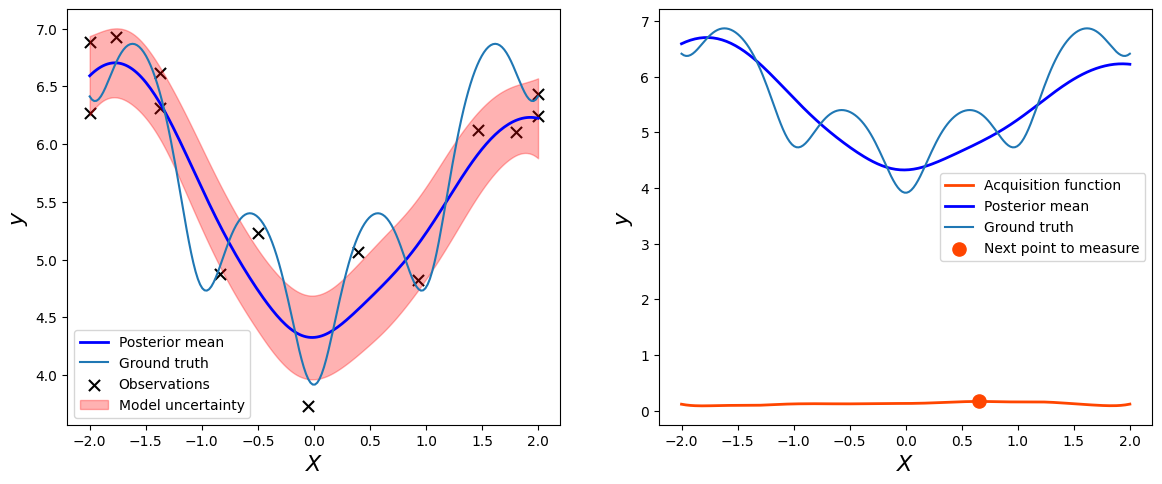


Step 6/25


sample: 100%|██████████| 4000/4000 [00:13<00:00, 286.07it/s, 7 steps of size 7.20e-01. acc. prob=0.89]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      1.68      0.25      1.74      1.33      2.00   1723.79      1.00
   k_scale      9.93      4.49      8.84      3.67     16.19   1355.86      1.00
     noise      0.39      0.22      0.34      0.11      0.69   1398.17      1.00




Step 7/25


sample: 100%|██████████| 4000/4000 [00:10<00:00, 387.42it/s, 3 steps of size 6.10e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      1.67      0.25      1.71      1.31      2.00   1938.27      1.00
   k_scale     10.17      5.07      8.97      3.75     16.87   1250.46      1.00
     noise      0.36      0.18      0.32      0.10      0.60   1449.04      1.00



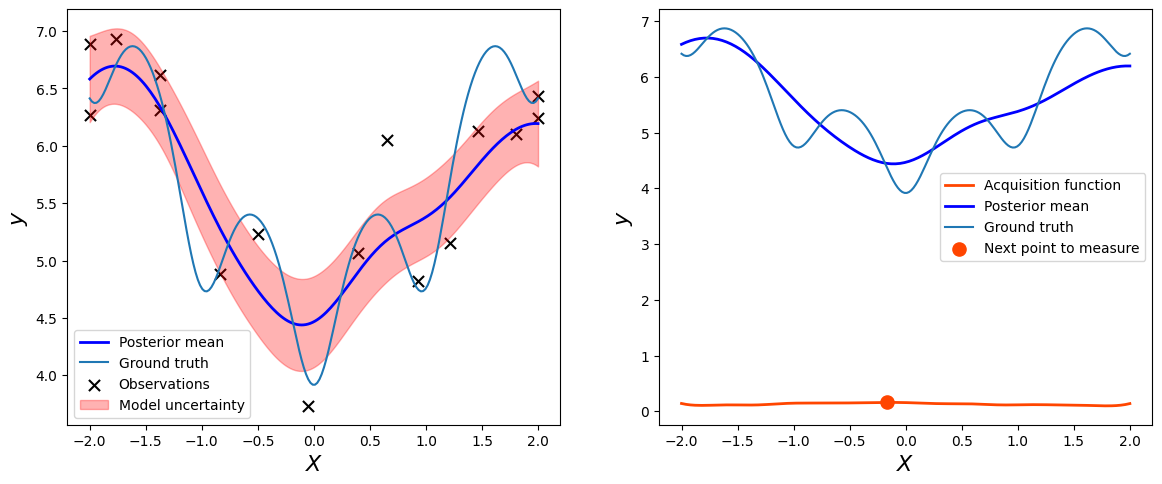


Step 8/25


sample: 100%|██████████| 4000/4000 [00:10<00:00, 377.59it/s, 7 steps of size 6.53e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      1.67      0.25      1.71      1.30      2.00   1654.38      1.00
   k_scale      9.83      4.35      8.92      3.85     15.73   1217.43      1.00
     noise      0.33      0.17      0.29      0.10      0.55   1620.63      1.00



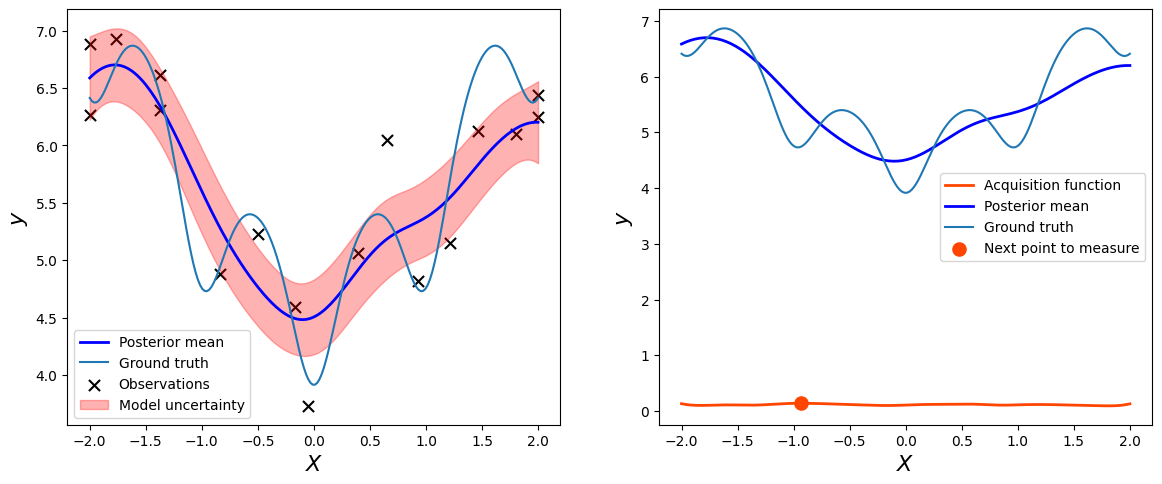


Step 9/25


sample: 100%|██████████| 4000/4000 [00:10<00:00, 367.89it/s, 7 steps of size 6.57e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      1.64      0.27      1.70      1.26      2.00   1622.71      1.00
   k_scale     10.29      4.77      9.28      3.84     16.79   1333.79      1.00
     noise      0.40      0.19      0.35      0.14      0.68   1663.04      1.00




Step 10/25


sample: 100%|██████████| 4000/4000 [00:11<00:00, 346.68it/s, 7 steps of size 6.70e-01. acc. prob=0.86]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      1.62      0.29      1.68      1.22      2.00   1153.11      1.00
   k_scale     10.56      5.18      9.30      3.68     17.34    918.81      1.00
     noise      0.36      0.18      0.32      0.11      0.61    960.60      1.00



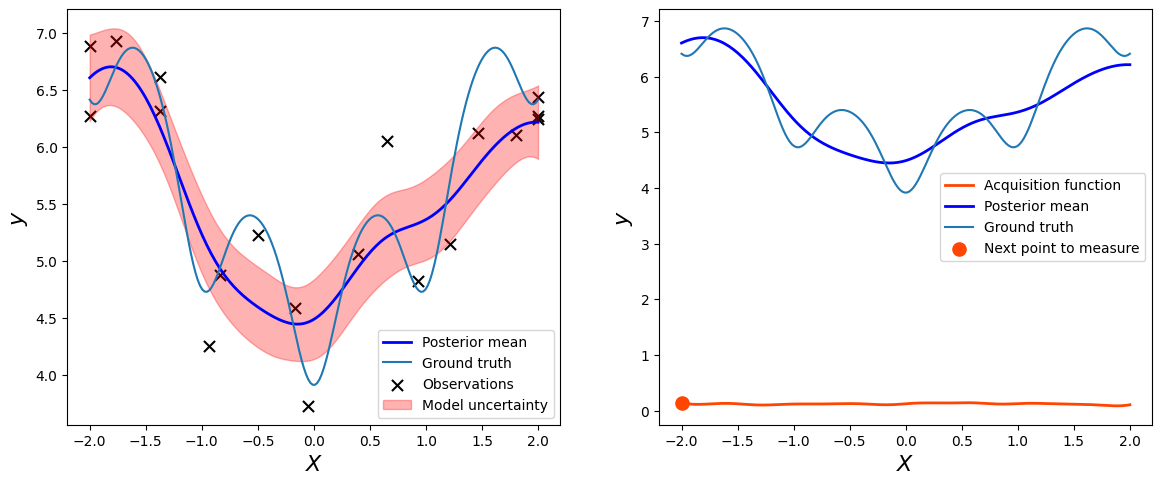


Step 11/25


sample: 100%|██████████| 4000/4000 [00:11<00:00, 361.65it/s, 7 steps of size 6.67e-01. acc. prob=0.83]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      1.60      0.31      1.67      1.13      2.00    594.10      1.00
   k_scale     10.75      5.16      9.51      3.87     17.84    806.67      1.00
     noise      0.32      0.16      0.29      0.07      0.54    874.75      1.00



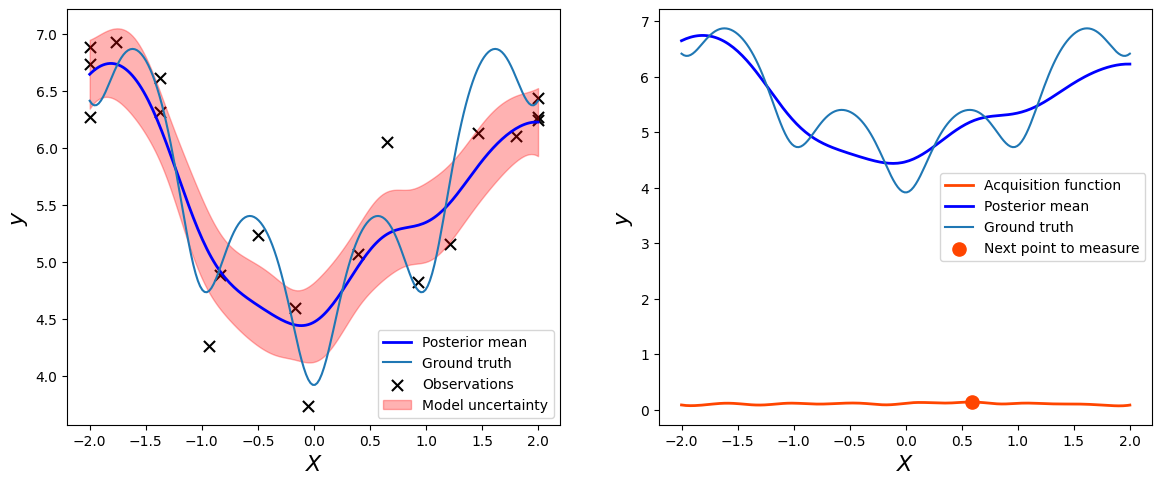


Step 12/25


sample: 100%|██████████| 4000/4000 [00:11<00:00, 342.83it/s, 7 steps of size 7.38e-01. acc. prob=0.80]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      1.59      0.31      1.65      1.11      2.00   1043.19      1.00
   k_scale     10.58      5.07      9.34      3.93     17.75    929.75      1.00
     noise      0.30      0.15      0.27      0.08      0.48   1017.35      1.00



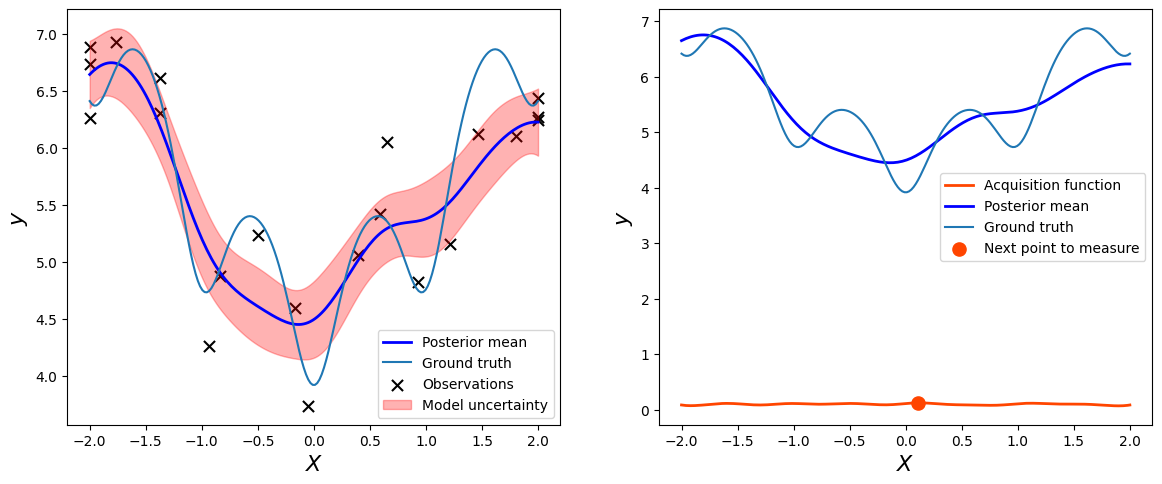


Step 13/25


sample: 100%|██████████| 4000/4000 [00:11<00:00, 347.16it/s, 3 steps of size 6.47e-01. acc. prob=0.73]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      1.50      0.37      1.57      0.96      2.00    377.65      1.00
   k_scale     11.18      5.34      9.93      4.12     18.68    743.26      1.00
     noise      0.29      0.15      0.27      0.07      0.49    503.56      1.00



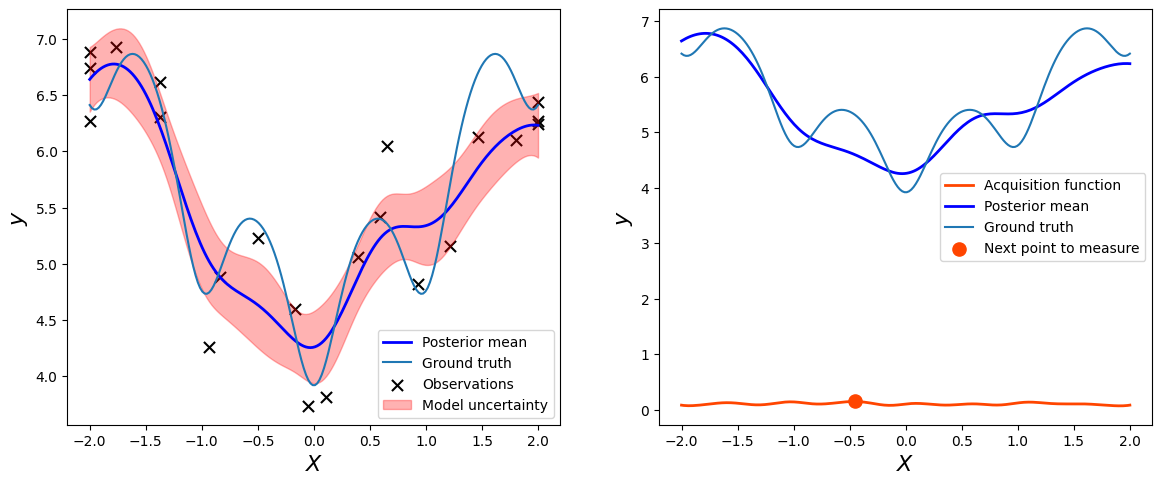


Step 14/25


sample: 100%|██████████| 4000/4000 [00:11<00:00, 334.48it/s, 3 steps of size 4.04e-01. acc. prob=0.82]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      1.38      0.40      1.39      0.85      2.00    489.80      1.00
   k_scale     11.37      5.39      9.95      4.51     19.00    870.93      1.00
     noise      0.25      0.15      0.23      0.04      0.45    655.15      1.00



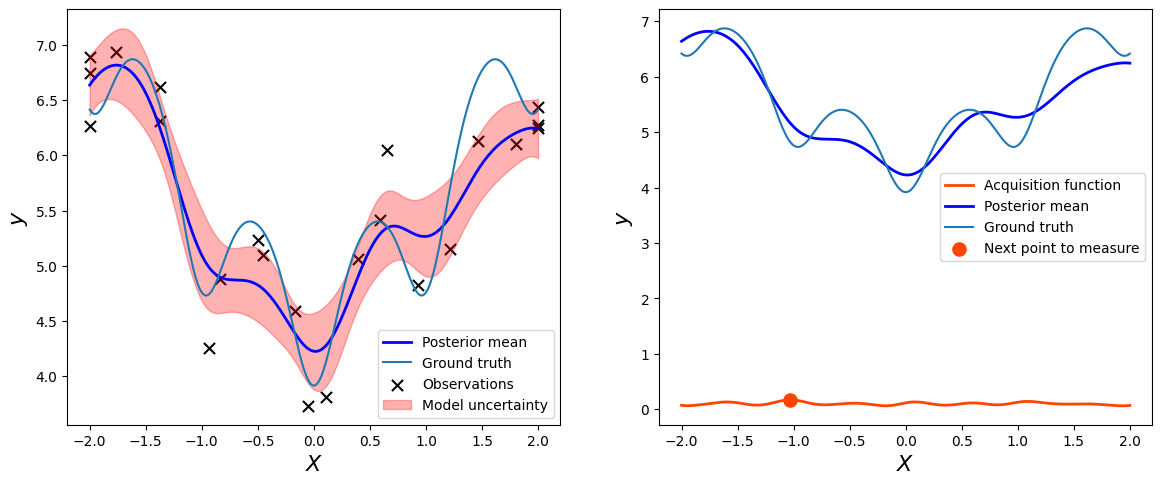


Step 15/25


sample: 100%|██████████| 4000/4000 [00:11<00:00, 342.11it/s, 7 steps of size 4.67e-01. acc. prob=0.73]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      1.33      0.39      1.26      0.85      1.99    496.47      1.00
   k_scale     11.98      6.18     10.56      4.26     19.21    633.63      1.00
     noise      0.22      0.14      0.19      0.04      0.40    558.51      1.00




Step 16/25


sample: 100%|██████████| 4000/4000 [00:12<00:00, 320.41it/s, 7 steps of size 3.83e-01. acc. prob=0.89]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      1.18      0.35      1.07      0.73      1.83    403.43      1.00
   k_scale     12.27      5.88     10.87      4.14     19.69    639.65      1.00
     noise      0.17      0.12      0.13      0.03      0.34    489.37      1.00




Step 17/25


sample: 100%|██████████| 4000/4000 [00:12<00:00, 331.10it/s, 1 steps of size 4.76e-01. acc. prob=0.88]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      1.15      0.33      1.05      0.69      1.76    450.96      1.01
   k_scale     12.61      6.61     11.14      4.45     20.57    935.26      1.00
     noise      0.15      0.11      0.12      0.03      0.30    511.62      1.00




Step 18/25


sample: 100%|██████████| 4000/4000 [00:12<00:00, 320.60it/s, 7 steps of size 4.76e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      1.09      0.28      1.02      0.67      1.52    401.07      1.00
   k_scale     12.89      6.55     11.32      4.65     20.96   1004.12      1.00
     noise      0.13      0.09      0.10      0.04      0.23    474.60      1.00



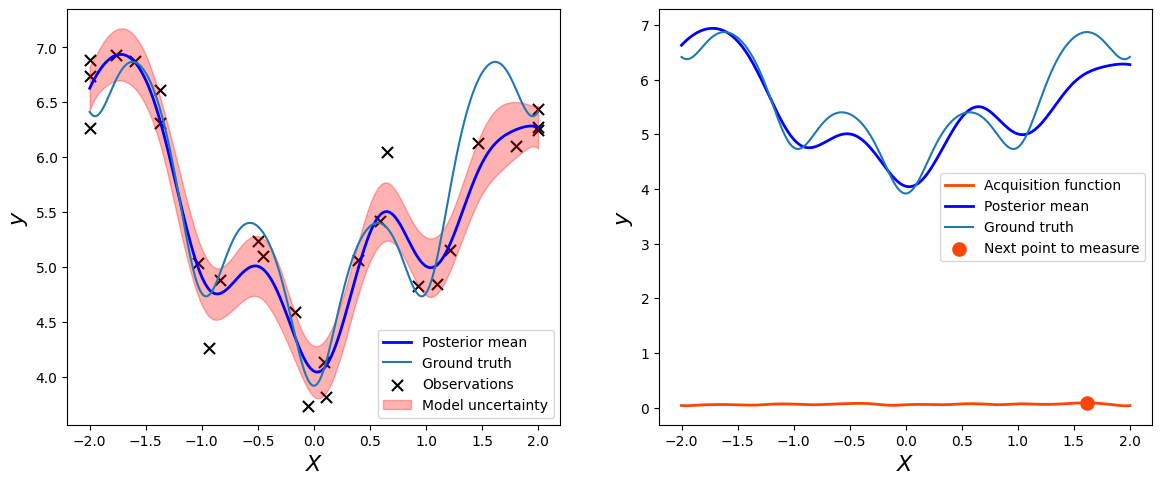


Step 19/25


sample: 100%|██████████| 4000/4000 [00:12<00:00, 332.18it/s, 3 steps of size 4.98e-01. acc. prob=0.87]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      1.06      0.25      1.00      0.66      1.39    556.94      1.00
   k_scale     13.12      6.56     11.59      4.86     21.27    858.68      1.00
     noise      0.12      0.07      0.10      0.04      0.22    480.43      1.00




Step 20/25


sample: 100%|██████████| 4000/4000 [00:12<00:00, 317.43it/s, 7 steps of size 3.97e-01. acc. prob=0.95] 



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.97      0.18      0.95      0.69      1.22    734.26      1.00
   k_scale     13.31      6.43     11.61      4.91     21.56    778.15      1.00
     noise      0.11      0.06      0.09      0.04      0.18    596.87      1.00



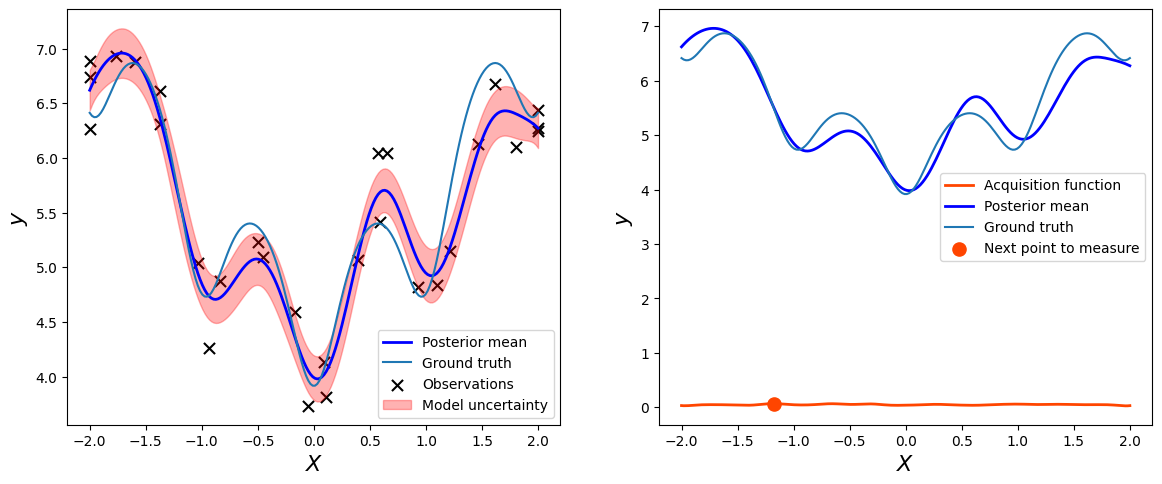


Step 21/25


sample: 100%|██████████| 4000/4000 [00:12<00:00, 320.45it/s, 3 steps of size 5.90e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.98      0.19      0.96      0.70      1.23    313.00      1.00
   k_scale     13.19      5.96     11.74      5.33     21.43   1044.39      1.00
     noise      0.10      0.06      0.09      0.04      0.17    447.97      1.00



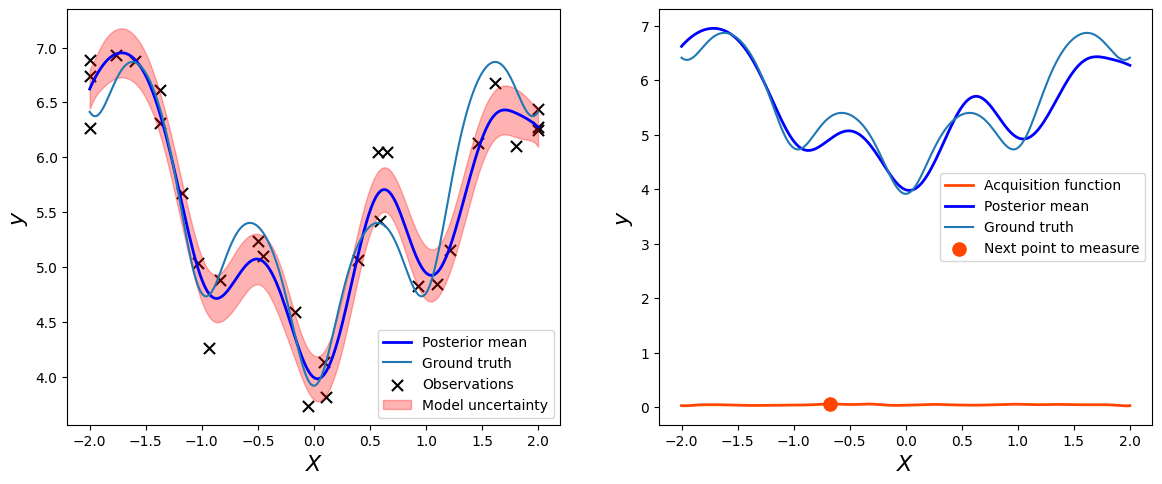


Step 22/25


sample: 100%|██████████| 4000/4000 [00:12<00:00, 308.59it/s, 7 steps of size 5.60e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.98      0.18      0.95      0.70      1.23    881.74      1.00
   k_scale     13.55      6.77     11.97      4.96     21.46    974.31      1.00
     noise      0.10      0.04      0.09      0.04      0.16   1174.17      1.00



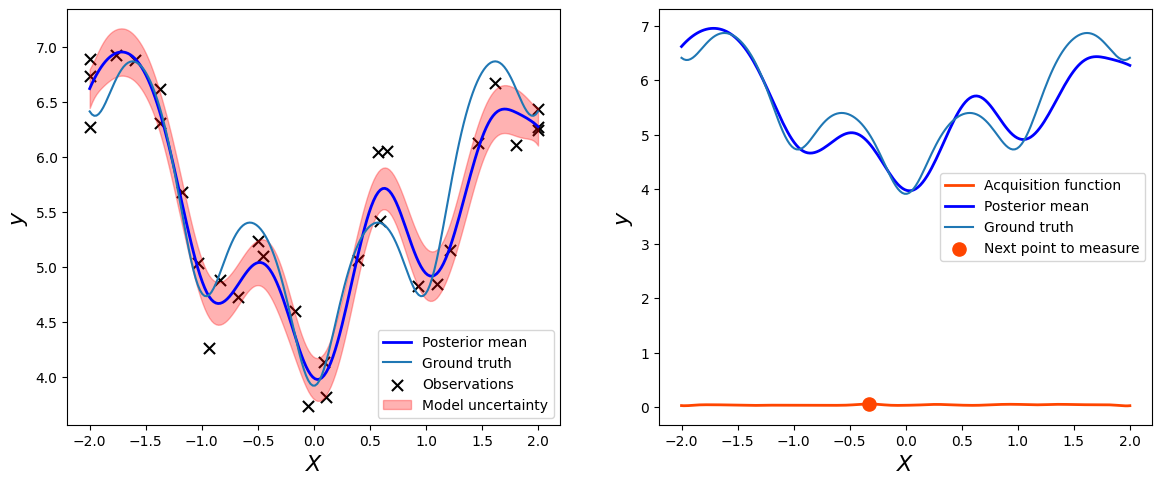


Step 23/25


sample: 100%|██████████| 4000/4000 [00:22<00:00, 174.47it/s, 7 steps of size 5.98e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.97      0.17      0.94      0.72      1.21    408.09      1.00
   k_scale     13.77      6.86     11.99      5.06     22.38   1058.25      1.00
     noise      0.09      0.04      0.08      0.04      0.14    368.76      1.01



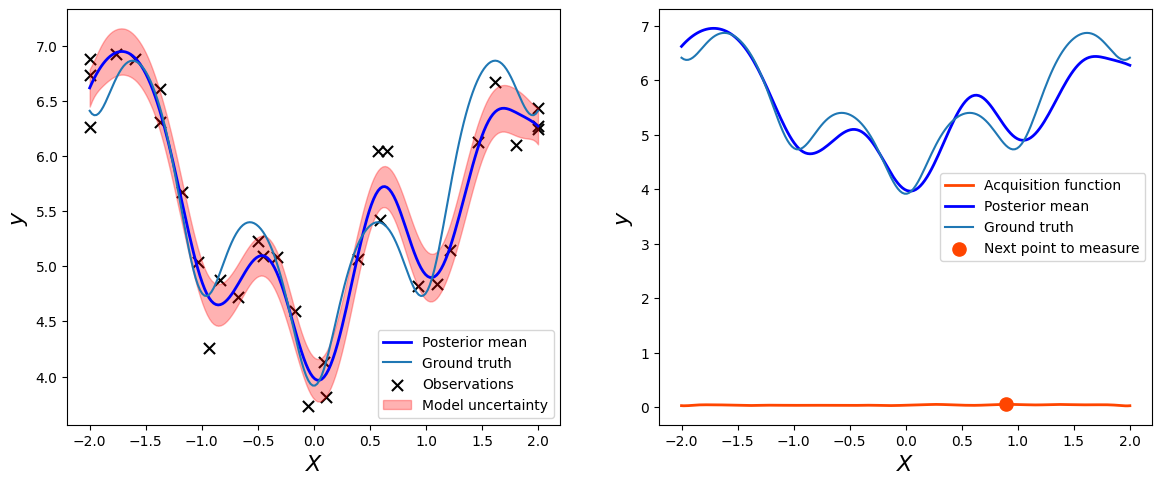


Step 24/25


sample: 100%|██████████| 4000/4000 [00:24<00:00, 165.19it/s, 7 steps of size 6.01e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.94      0.16      0.92      0.70      1.18    453.90      1.00
   k_scale     13.81      6.70     12.25      5.27     22.30    992.43      1.00
     noise      0.09      0.04      0.08      0.04      0.14    424.82      1.01



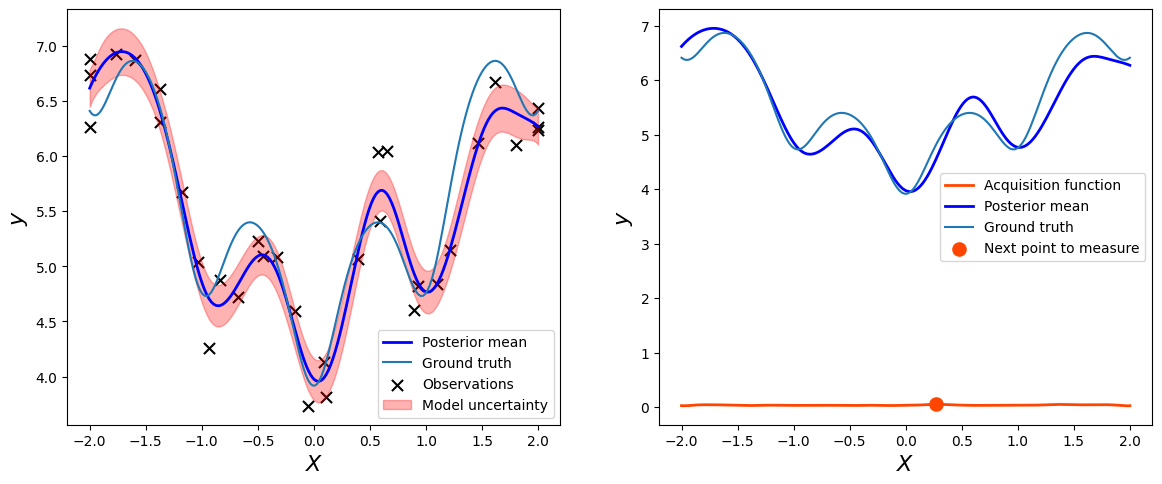


Step 25/25


sample: 100%|██████████| 4000/4000 [00:25<00:00, 154.59it/s, 7 steps of size 5.71e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  k_length      0.95      0.15      0.94      0.71      1.20   1207.97      1.00
   k_scale     13.78      6.68     12.14      5.42     22.44    918.89      1.00
     noise      0.10      0.04      0.09      0.04      0.14   1359.06      1.00



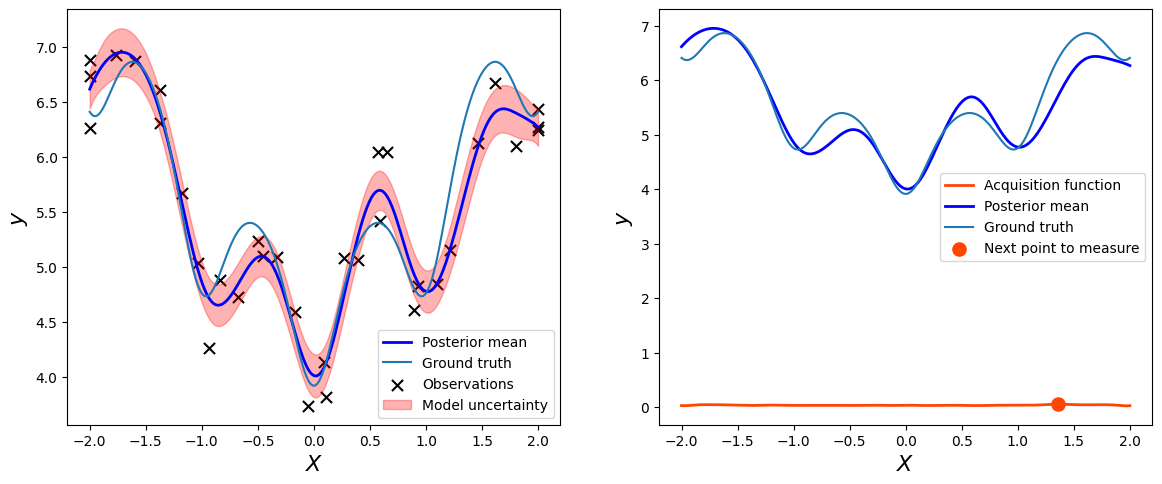

In [ ]:
num_steps = 25

for e in range(num_steps):
    print("\nStep {}/{}".format(e+1, num_steps))
    # Compute acquisition function
    acq, (y_pred, y_sampled) = step(X, y, X_unmeasured)
    # Get the next point to evaluate
    idx = acq.argmax()
    next_point = X_unmeasured[idx:idx+1]
    # Measure the point
    next_point_value = measure(next_point)
    # Update measured data
    X = np.append(X, X_unmeasured[idx:idx+1])
    y = np.append(y, next_point_value)

    # Plot observed points, mean prediction, and acqusition function
    lower_b = y_pred - y_sampled.std(axis=(0,1))
    upper_b = y_pred + y_sampled.std(axis=(0,1))
    fig, (ax1, ax2) = plt.subplots(1, 2, dpi=100, figsize=(14, 5.5))
    ax1.scatter(X[:-1], y[:-1], marker='x', c='k', label="Observations", s=64)
    ax1.fill_between(X_unmeasured, lower_b, upper_b, color='r', alpha=0.3, label="Model uncertainty")
    ax2.plot(X_unmeasured, acq, lw=2, c='orangered', label='Acquisition function')
    ax2.scatter(X_unmeasured[idx], acq[idx], s=90, c='orangered', label='Next point to measure')
    for ax in fig.axes:
        ax.plot(X_unmeasured, y_pred, lw=2, c='b', label='Posterior mean')
        ax.plot(X_unmeasured, ground_truth, label='Ground truth')
        #ax.set_ylim(3.0, 8)
        ax.set_xlabel("$X$", fontsize=16)
        ax.set_ylabel("$y$", fontsize=16)
        ax.legend(loc='best', fontsize=10)
    plt.show()

As one can see, the algorithm quickly converged onto the true minimum. Note that in real experiments, it's practical to update the ```X_unmeasured``` at each step by removing the just measured point from it.